# Membership Inference

## Setup

In [1]:
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats

sns.set(rc={'figure.figsize': (7, 7)}, font_scale=1.5)
sns.set_style('white')

In [2]:
MECHANISMS = ('gaussian', 'round')

def mem_infer(n_samples, n_dim, sigma, n_trials=10**4, mechanism='gaussian', tnr=0.95):
    
    assert mechanism in MECHANISMS
    
    X = np.random.choice((-1, 1), size=(n_samples, n_dim))
    X_mean = np.mean(X, axis=0)
    
    if mechanism == 'gaussian':
        Z = np.random.normal(scale=sigma, size=n_dim)
        A = X_mean + Z
    else:
        A = (X_mean / sigma).round() * sigma

    T_in = X[np.random.choice(X.shape[0], size=n_trials, replace=True)]
    T_out = np.random.choice((-1, 1), size=(n_trials, n_dim))

    scores_in = T_in @ A
    scores_out = T_out @ A

    threshold = np.quantile(scores_out, tnr)
    tpr = np.mean(scores_in > threshold)

    return tpr, scores_in, scores_out

## Mean and Variance Estimation for one Configuration

In [3]:
%%time

_, scores_in, scores_out = mem_infer(n_samples=100, n_dim=400, sigma=0.01, n_trials=10**5)

df = pd.DataFrame({'In': scores_in, 'Out': scores_out}).describe()

df

CPU times: user 952 ms, sys: 582 ms, total: 1.53 s
Wall time: 1.29 s


,In,Out
count,100000.000000,100000.000000
mean,3.476925,-0.001684
std,1.723328,1.880435
min,-2.313580,-8.158405
25%,2.408047,-1.263669
50%,3.500230,0.001109
75%,4.687041,1.267816
max,7.319775,8.032139


## Experiments

In [4]:
SIGMAS = [0.01, 1/3]
N_DIMS = [100, 200, 400, 800, 2000]

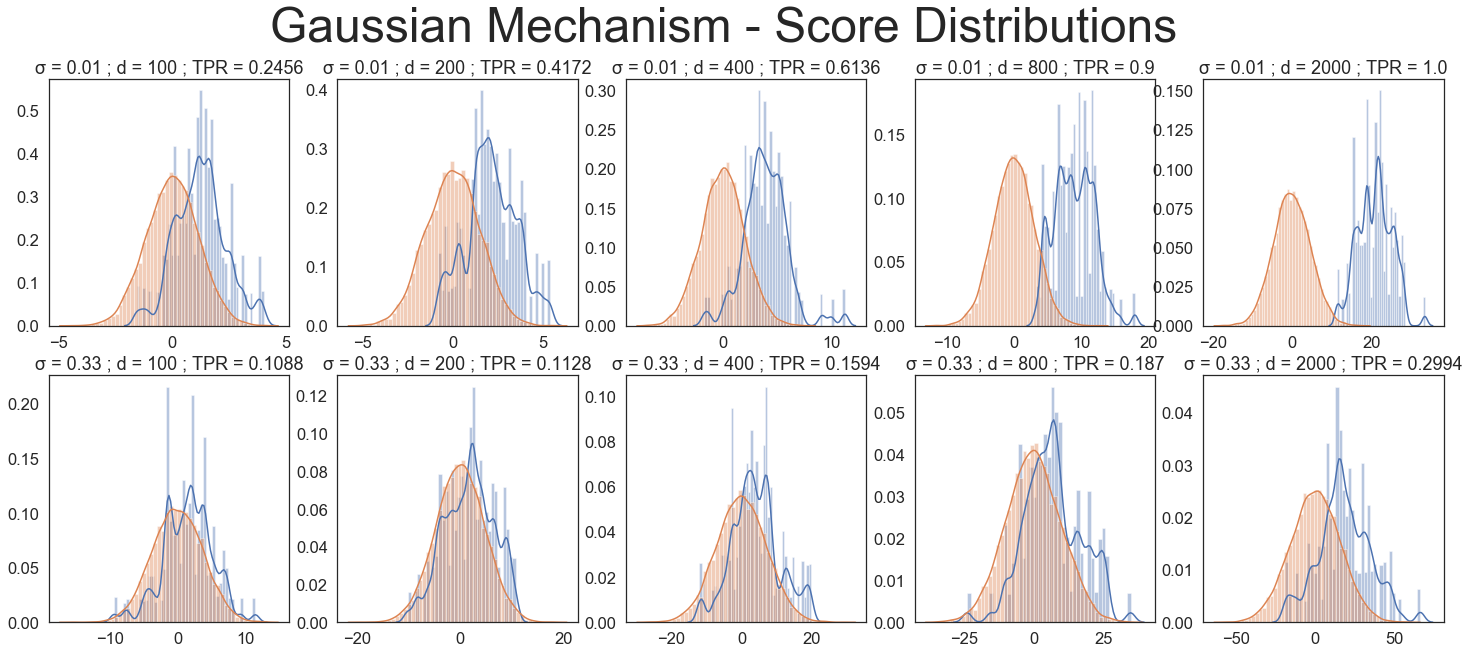

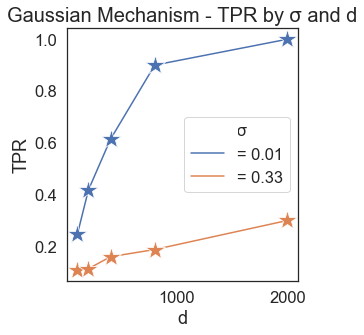

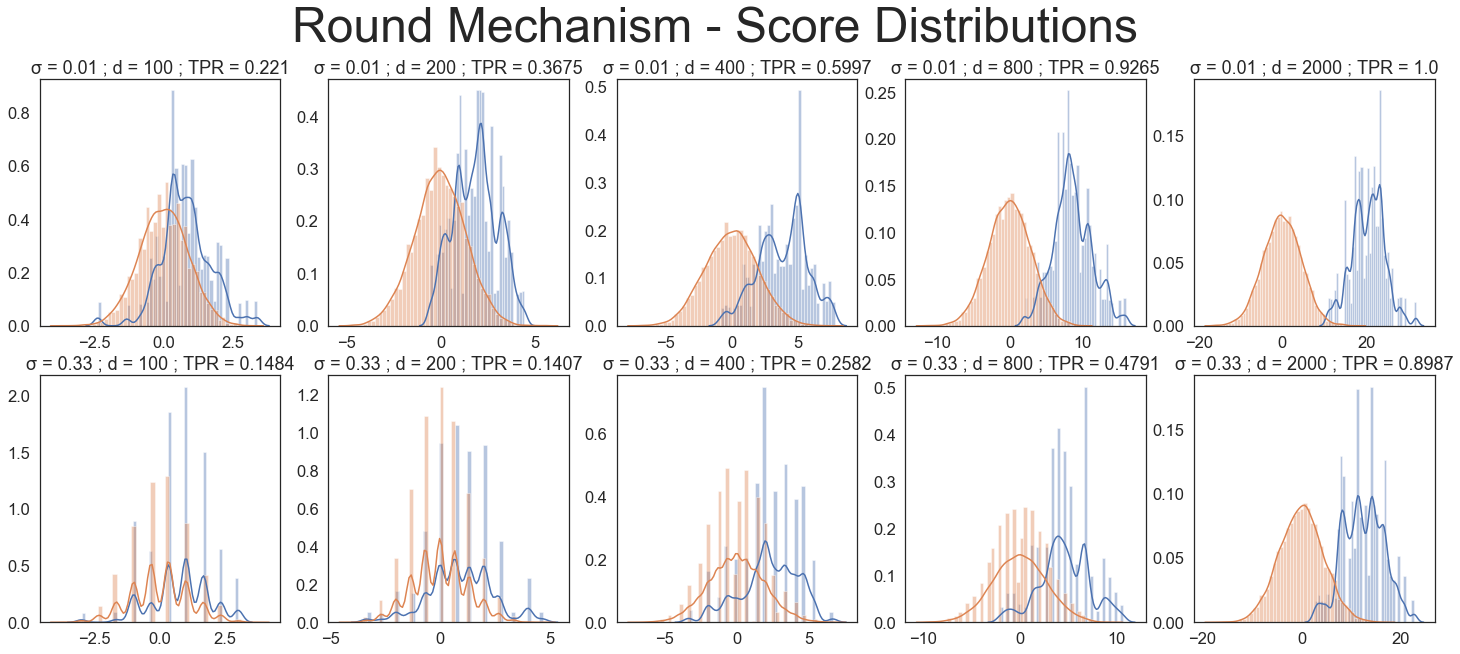

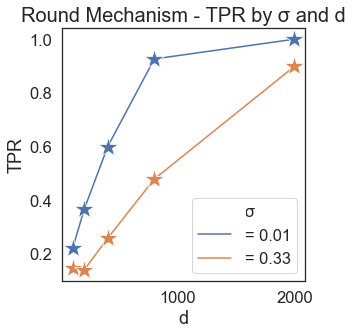

In [5]:
for mechanism in MECHANISMS:
    all_tprs = []
    
    f, axes = plt.subplots(len(SIGMAS), len(N_DIMS), figsize=(25, 10))
    
    f.suptitle(f'{mechanism.title()} Mechanism - Score Distributions', fontsize=48)
    
    for sigma, row_axes in zip(SIGMAS, axes):
        for n_dim, ax in zip(N_DIMS, row_axes):
    
            tpr, scores_in, scores_out = mem_infer(100, n_dim, sigma,
                                                   mechanism=mechanism)
            
            sns.distplot(scores_in, hist=True, label='In', ax=ax)
            sns.distplot(scores_out, hist=True, label='Out', ax=ax)
            ax.set_title(f'σ = {sigma:.2f} ; d = {n_dim} ; TPR = {tpr}')
                          
            all_tprs.append({'σ': f'= {sigma:.2f}', 'd': n_dim, 'TPR': tpr})
    
    f.savefig(f'./plots/mem-infer-{mechanism}-dists.png', dpi=300)
    
    
    f, ax = plt.subplots(1, figsize=(5, 5))
    
    ax.set_title(f'{mechanism.title()} Mechanism - TPR by σ and d', fontsize=20)

    sns.lineplot(x='d', y='TPR', hue='σ', style='σ',
                 marker='*', markersize=20, dashes=False,
                 data=pd.DataFrame(all_tprs),
                 ax=ax)

    plt.tight_layout()
    
    f.savefig(f'./plots/mem-infer-{mechanism}-tpr.png', dpi=300)